# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** Regression is used to predict continuous values. Classification is used to predict which class a data point is part of (discrete value). In this case, given a student, we would like to assign the classes “yes, need early intervention” and “no” to that student, so this is classification problem.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [6]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# student_data.info


Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


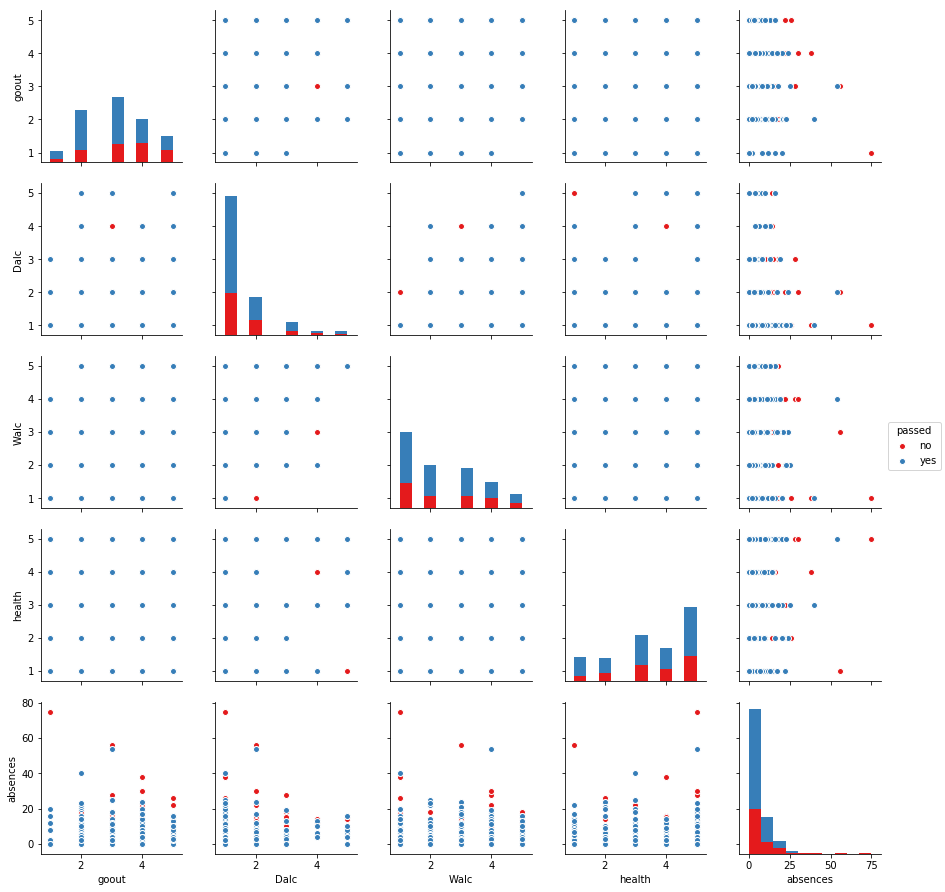

In [7]:
# TODO: Calculate number of students
shapes = student_data.shape

n_students = shapes[0]

# TODO: Calculate number of features
n_features = shapes[1] - 1

# TODO: Calculate passing students
n_passed = student_data[student_data['passed']=='yes']['passed'].count()

# TODO: Calculate failing students
n_failed = student_data[student_data['passed']=='no']['passed'].count()

# TODO: Calculate graduation rate
grad_rate = np.float32(n_passed)/np.float32(n_students) * 100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

# REVISION POST REVIEW No.1
import seaborn as sns
student_data.describe()
sns.pairplot(student_data.iloc[:,25:], palette='Set1', hue='passed')

# OBSERVATION -
#  Out of those 395 students, 265 passed and 130 failed.
#  So label data is unbalanced
#
#
#
#


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [8]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [9]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [5]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300 # about 75% of the data

# Set the number of testing points
num_test = X_all.shape[0] - num_train

#
# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, stratify = y_all, random_state=42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

Observations a) size of data set is small b) label data is slightly unbalanced

List all referneces (REVISION POST REVIEW No.1)
- http://scikit-learn.org/stable/tutorial/machine_learning_map/
- https://static.coggle.it/diagram/WHeBqDIrJRk-kDDY
- http://arogozhnikov.github.io/2016/04/28/demonstrations-for-ml-courses.html
- https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html


The following 3 classifiers are selected 

1) Logistic Regression

2) SVC

3) Gaussian Naive Bayes

-Logistic Regression
```
Real world : http://blog.minitab.com/blog/real-world-quality-improvement/using-binary-logistic-regression-to-investigate-high-employee-turnover
good :
Can be regularized to avoid overfitting and can be updated easily with new data using stochastic gradient descent.
bad : tends to underperform when there are multiple or non-linear decision boundaries. They are not flexible enough to naturally capture more complex relationships.
```

- Support Vector Machines (SVMs)
```
Real world : https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-10-16
"We present a potentially useful alternative approach based on support vector machine (SVM) techniques to classify persons with and without common diseases. We illustrate the method to detect persons with diabetes and pre-diabetes in a cross-sectional representative sample of the U.S. population."

good:
It has many kernels to choose from. They are also fairly robust against overfitting
bad: 
SVMs scale exponentially in training time
SVM's are memory intensive, trickier to tune due to the importance of picking the right kernel,
```

-Naive Bayes
```
Real world : http://ieeexplore.ieee.org/document/6282321/?reload=true "An application of Naive Bayes classification for credit scoring in e-lending platform"
good :

good:
Perform surprisingly well in practice, especially for how simple they are. They are easy to implement and can scale with your dataset.
bad:
Requires observations to be independent of one another
```




### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [11]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)
    
    return end - start

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes'), end - start


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [12]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# TODO: Initialize the three models
#clf_A = 
#clf_B = 
#clf_C = 

# TODO: Set up the training set sizes
#X_train_100 = None
#y_train_100 = None

#X_train_200 = None
#y_train_200 = None

#X_train_300 = None
#y_train_300 = None

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)  
classifiers = [LogisticRegression(), SVC(), GaussianNB()]
results = {
    'Classifier': [],
    'Size': [],
    'Train time': [],
    'predict time': [],
    'F1 score - train': [],
    'F1 score - test': []
}

datasets = [train_test_split(X_all, y_all, train_size=x, test_size=95) for x in [100, 200, 300]]

for clf in classifiers:
    for data in datasets:
        X_train, X_test, y_train, y_test = data
        time_train = train_classifier(clf, X_train, y_train)
        f1_train, time_predict = predict_labels(clf, X_train, y_train)
        f1_test, time_predict = predict_labels(clf, X_test, y_test)

        results['Classifier'].append(clf.__class__.__name__)
        results['Size'].append(X_train.shape[0])
        results['Train time'].append("{:.4f}".format(time_train))
        results['predict time'].append("{:.4f}".format(time_predict))
        results['F1 score - train'].append(f1_train)
        results['F1 score - test'].append(f1_test) 
 
pd.DataFrame(results)   

Trained model in 0.0030 seconds
Made predictions in 0.0006 seconds.
Made predictions in 0.0003 seconds.
Trained model in 0.0016 seconds
Made predictions in 0.0016 seconds.
Made predictions in 0.0002 seconds.
Trained model in 0.0026 seconds
Made predictions in 0.0004 seconds.
Made predictions in 0.0002 seconds.
Trained model in 0.0028 seconds
Made predictions in 0.0014 seconds.
Made predictions in 0.0010 seconds.
Trained model in 0.0042 seconds
Made predictions in 0.0027 seconds.
Made predictions in 0.0011 seconds.
Trained model in 0.0078 seconds
Made predictions in 0.0058 seconds.
Made predictions in 0.0020 seconds.
Trained model in 0.0008 seconds
Made predictions in 0.0006 seconds.
Made predictions in 0.0003 seconds.
Trained model in 0.0010 seconds
Made predictions in 0.0008 seconds.
Made predictions in 0.0006 seconds.
Trained model in 0.0020 seconds
Made predictions in 0.0009 seconds.
Made predictions in 0.0004 seconds.


,Classifier,F1 score - test,F1 score - train,Size,Train time,predict time
0,LogisticRegression,0.707692,0.893333,100,0.0030,0.0003
1,LogisticRegression,0.758065,0.851351,200,0.0016,0.0002
2,LogisticRegression,0.750000,0.837104,300,0.0026,0.0002
3,SVC,0.750000,0.848485,100,0.0028,0.0010
4,SVC,0.739726,0.862500,200,0.0042,0.0011
5,SVC,0.765101,0.885529,300,0.0078,0.0020
6,GaussianNB,0.712121,0.825175,100,0.0008,0.0003
7,GaussianNB,0.683761,0.805654,200,0.0010,0.0006
8,GaussianNB,0.751880,0.802956,300,0.0020,0.0004


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

|    Classifier    |F1 score - test|F1 score - train|Size|Train time|predict time|
|------------------|--------------:|---------------:|---:|---------:|-----------:|
|LogisticRegression|         0.7402|          0.8671| 100|   0.00411|     0.00018|
|LogisticRegression|         0.7313|          0.8682| 200|   0.00188|     0.00017|
|LogisticRegression|         0.7941|          0.8352| 300|   0.00231|     0.00017|



|Classifier|F1 score - test|F1 score - train|Size|Train time|predict time|
|----------|--------------:|---------------:|---:|---------:|-----------:|
|SVC       |         0.7815|          0.8535| 100|   0.00395|     0.00082|
|SVC       |         0.7919|          0.8882| 200|   0.00313|     0.00103|
|SVC       |         0.7867|          0.8662| 300|   0.00766|     0.00148|


|Classifier|F1 score - test|F1 score - train|Size|Train time|predict time|
|----------|--------------:|---------------:|---:|---------:|-----------:|
|GaussianNB|         0.4000|          0.5217| 100|   0.00125|     0.00035|
|GaussianNB|         0.6726|          0.7794| 200|   0.00131|     0.00028|
|GaussianNB|         0.7914|          0.8314| 300|   0.00087|     0.00025|


## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

SVC has the best prediction performance across all sampling size compared with LogisticRegression and GaussianNB but it takes too long for both training and prediction.

GaussianNB due to its too-simple model nature, its performance varies very much.

So I choose among these three models logistic-regression model



### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

(First attempt)
As the goal is to learn whether and how much the feature set will lead to whether a student will graduate or not. Intuitively we use divide-by-conqueue method and think to learn how we can make decision on each feature itself. With training data, we can learn the likelyhood impact from each of factors/features and we accumulate all together as a model.

(Second attempt - REVISION POST REVIEW No.1)

Whether a student will graduate or not are a binary data(named as `y`, 1 for passed=yes, 0 for passed=no).

To predict from one feature(`x1`) to `y`, we bascailly want to find a relationship y= functionA(x1) where y is 1 or 0. This functionA would be `Logit Regression or Logit Model` ![image_name.png](http://www.saedsayad.com/images/LogReg_1.png) It shows the probability for y being 1 for a given x1 value. 

To extend to predict multi features to binary label, that is logistic regression or the other name called `Multinomial Logistic Regression`

Refer to http://www.saedsayad.com/logistic_regression.htm, In the logistic regression the constant (b0) moves the curve left and right and the slope (b1) defines the steepness of the curve. By simple transformation, the logistic regression equation can be written in terms of an odds ratio.


In [13]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.metrics import f1_score
from sklearn.cross_validation import train_test_split

parameters = [
  {'C': np.logspace(-4, 10, num=100),
   'max_iter': [1000]}
 ]

# TODO: Initialize the classifier
clf = LogisticRegression(random_state=42)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer, cv=5, verbose=0)

# REVISION POST REVIEW No.1
# COMMENT OUT LINE BELOW
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=300, test_size=95)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
result_train, time_train = predict_labels(clf, X_train, y_train)
print "Tuned model has a training F1 score of {:.4f}.".format(result_train)
result_test, time_test = predict_labels(clf, X_test, y_test)
print "Tuned model has a testing F1 score of {:.4f}.".format(result_test)

Made predictions in 0.0002 seconds.
Tuned model has a training F1 score of 0.8330.
Made predictions in 0.0003 seconds.
Tuned model has a testing F1 score of 0.7568.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **
          train, test
untuned - 0.8352, 0.7941
tuned   - 0.8344, 0.8138

the score of test increased!

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.